# Visual Question Answering with LSTM and VGG features

In this notebook, we build a VQA model with LSTM as the language model and the VGG-19 as our visual model. Since the full dataset is quite large, we load and play with a small portion of it on our local machine. 

In [1]:
# don't re-inventing the wheel
import h5py, json, spacy

import numpy as np
import cPickle as pickle

%matplotlib inline
import matplotlib.pyplot as plt

from model import LSTMModel
from utils import prepare_ques_batch, prepare_im_batch

Using TensorFlow backend.


### Word Embeddings
For word embeddings, we use the pre-trained `word2vec` provided by the `spacy` package

In [2]:
# run `python -m spacy.en.download` to collect the embeddings (1st time only)
embeddings = spacy.en.English()
word_dim = 300

### Loading Tiny Dataset
Here we load a tiny dataset of 300 question/answer pairs and 100 images which is prepared using the script in `Dataset Handling.ipynb`

In [3]:
h5_img_file_tiny = h5py.File('data/vqa_data_img_vgg_train_tiny.h5', 'r')
fv_im_tiny = h5_img_file_tiny.get('/images_train')

with open('data/qa_data_train_tiny.pkl', 'rb') as fp:
    qa_data_tiny = pickle.load(fp)

json_file = json.load(open('data/vqa_data_prepro.json', 'r'))
ix_to_word = json_file['ix_to_word']
ix_to_ans = json_file['ix_to_ans']

vocab_size = len(ix_to_word)
print "Loading tiny dataset of %d image features and %d question/answer pairs for training." % (len(fv_im_tiny), len(qa_data_tiny)) 

Loading tiny dataset of 100 image features and 300 question/answer pairs for training.


In this dataset, one image associates with muiltiple question/answer pairs (3 in this case). Therefore, we need to hand-binding the question/answer pairs with the corresponding image feature for training.

In [6]:
questions, ques_len, im_ix, ans = zip(*qa_data_tiny)

nb_classes = 1000
max_ques_len = 26

X_ques = prepare_ques_batch(questions, ques_len, max_ques_len, embeddings, word_dim, ix_to_word)
X_im = prepare_im_batch(fv_im_tiny, im_ix)
y = np.zeros((len(ans), nb_classes))
y[np.arange(len(ans)), ans] = 1

### Overfit LSTM + VGG
Finally, we are getting to the fun part! Let's build our model...

In [7]:
model = LSTMModel()
model.build()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
bidirectional_1 (Bidirectional)  (None, 1024)          3330048                                      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 7, 7, 512)     0                                            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 25088)         0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 4096)          102764544                                    
___________________________________________________________________________________________

Since the dataset we are using is *tiny*, we can fit the whole dataset to the convenience `fit` method and specify the `batch_size`. Note that this already ate up a lot of memory and it won't work for the large dataset.

In [8]:
loss = model.fit(X_ques, X_im, y, nb_epoch=50, batch_size=50)

Epoch 1/50
300/300 [==============================] - 73s - loss: 7.9907 - acc: 0.0100     
Epoch 2/50
300/300 [==============================] - 50s - loss: 4.6486 - acc: 0.2500    
Epoch 3/50
300/300 [==============================] - 55s - loss: 2.7681 - acc: 0.5133    
Epoch 4/50
300/300 [==============================] - 49s - loss: 1.7249 - acc: 0.6600    
Epoch 5/50
300/300 [==============================] - 48s - loss: 1.2428 - acc: 0.6800    
Epoch 6/50
300/300 [==============================] - 60s - loss: 1.0568 - acc: 0.7200    
Epoch 7/50
300/300 [==============================] - 59s - loss: 0.7550 - acc: 0.7800     
Epoch 8/50
300/300 [==============================] - 51s - loss: 0.6932 - acc: 0.8200    
Epoch 9/50
300/300 [==============================] - 43s - loss: 0.5585 - acc: 0.8267    
Epoch 10/50
300/300 [==============================] - 48s - loss: 0.5268 - acc: 0.8533    
Epoch 11/50
300/300 [==============================] - 52s - loss: 0.4691 - acc: 0.8667

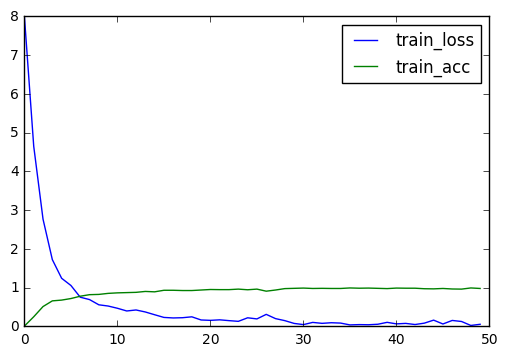

In [9]:
plt.plot(loss.history['loss'], label='train_loss')
plt.plot(loss.history['acc'], label='train_acc')
plt.legend(loc='best')

Let's see how far we can get with this overfitted model...

In [10]:
h5_img_file_test_tiny = h5py.File('data/vqa_data_img_vgg_test_tiny.h5', 'r')
fv_im_test_tiny = h5_img_file_test_tiny.get('/images_test')

with open('data/qa_data_test_tiny.pkl', 'rb') as fp:
    qa_data_test_tiny = pickle.load(fp)
    
print "Loading tiny dataset of %d image features and %d question/answer pairs for testing" % (len(fv_im_test_tiny), len(qa_data_test_tiny)) 

Loading tiny dataset of 100 image features and 300 question/answer pairs for testing


In [11]:
questions, ques_len, im_ix, ans = zip(*qa_data_test_tiny)

X_ques_test = prepare_ques_batch(questions, ques_len, max_ques_len, embeddings, word_dim, ix_to_word)
X_im_test = prepare_im_batch(fv_im_test_tiny, im_ix)
y_test = np.zeros((len(ans), nb_classes))
y_test[np.arange(len(ans)), [494 if a > 1000 else a for a in ans]] = 1

In [12]:
loss, acc = model.evaluate(X_ques_test, X_im_test, y_test)

300/300 [==============================] - 5s     


In [13]:
print loss, acc

4.7170976003 0.246666664879
